In [1]:
import tANS_py

In [31]:
# Testing code 

s = ["A","B","C"]
freq = [6, 2, 24]
t = DecodeTable(32, s, freq, fast = False)
g = Encoder(32, s,freq,t.symbol_spread)
msg = "CAACACCCCCCCCBCCCACCCACCCACCCBCC"
msg_temp = list(msg)
bit = g.encode(msg_temp)

print("".join([str(i) for i in bit]), "011011110000010010110001010010101")

out = t.decode(bit)
out.reverse()
"".join(out) == msg

0101100100010100100011001010000010001101011 011011110000010010110001010010101


True

# Coder
This class combines the encoding and decoding classes to provide a complete ANS coder. It has the following methods:
* `encode`: Encodes a message using the ANS algorithm.
* `decode`: Decodes a message using the ANS algorithm.
* `encode_decode`: Encodes and then decodes a message to check for correctness.
* `encode_decode_string`: Encodes and then decodes a string message to check for correctness.

The `encode_decode` method also returns the number of bits saved.

In [32]:
class Coder:
    def __init__(self, L, s_list, L_s, fast = False):
        """Initializes the coder

        Args:
            s_list (list): list of symbols in the message
            L_s (list): list of frequencies of the symbols
        """
        self.s_list = s_list
        self.L_s = L_s
        self.L = L
                        
        # initialize the decoding table
        self.decoding_table = DecodeTable(self.L, s_list, L_s, fast= fast)
        
        # spread symbols using the spread function
        self.spread = self.decoding_table.symbol_spread
        
        # initialize the encoder
        self.encoder = Encoder(self.L, s_list, L_s, self.spread)
        
    def encode(self, data):
        """Encodes the data using the encoder

        Args:
            data (list): a list of symbols to encode

        Returns:
            list: returns the bitstream
        """
        return self.encoder.encode(data)
    
    def decode(self, bitstream):
        """Decodes the bitstream using the decoding table

        Args:
            bitstream (list): the bitstream to decode

        Returns:
            list: returns the decoded symbols
        """
        # note we reverse the decoded symbols since the bitstream is decoded in opposite order
        res = self.decoding_table.decode(bitstream)
        res.reverse()
        return res
    
    @staticmethod
    def calculate_bits(number):
        if number == 0:
            return 1  # Special case for zero
        num_bits = 0
        while number:
            number >>= 1  # Right shift by 1 bit
            num_bits += 1
        return num_bits
    
    def encode_decode(self, data, verbose = False):
        """Encodes and decodes the data, and returns the decoded data

        Args:
            data (list): a list of symbols to encode and decode

        Returns:
            list: returns the decoded symbols
        """
        
        bitstream = self.encode(data)
        res = self.decode(bitstream)
        # if there is an error 
        if res != data:
            print("Error in encoding and decoding")
            
        # compute how many bits saved
        orig_bits = len(data) * Coder.calculate_bits(len(self.s_list))
        comp_bits = len(bitstream)
        
        if verbose:
            print("Original bits: %d, Compressed bits: %d, Saved: %d" % (orig_bits, comp_bits, orig_bits - comp_bits))
        
        return res, orig_bits / comp_bits
    
    def encode_decode_string(self, data):
        """Encodes and decodes the string data, and returns the decoded data

        Args:
            data (str): a string to encode and decode

        Returns:
            list: returns the decoded symbols
        """
        data_t = list(data)
        print(data_t)
        return "".join(self.encode_decode(data_t)[0])

In [33]:
# Generate random string
import random

def generate_random_string(alphabet, frequencies):
    population = []
    
    # Create the population list based on frequencies
    for symbol, freq in zip(alphabet, frequencies):
        population.extend([symbol] * freq)
    
    # Shuffle the population to ensure randomness
    random.shuffle(population)
    
    # Join the list into a string
    random_string = ''.join(population)
    
    return random_string

def generate_random_list(l, n):
    return [random.randint(0, n) for _ in range(l)]

def next_power_of_2(x):
    return 1 if x == 0 else 2**((int(x) - 1).bit_length())

def generate_random_list2(l, n):
    if l <= 0:
        raise ValueError("Length of the list must be positive.")
    
    # Generate the initial list of random numbers
    random_list = [random.randint(1, n) for _ in range(l)]
    total_sum = sum(random_list)
    
    # Find the next power of 2 greater than or equal to total_sum
    target_sum = next_power_of_2(total_sum)
    
    # Calculate the adjustment needed
    adjustment = target_sum - total_sum
    
    # Ensure the last element remains positive
    if random_list[-1] + adjustment <= 0:
        # Adjust another element if the last element would become non-positive
        for i in range(l-1):
            if random_list[i] + adjustment > 0:
                random_list[i] += adjustment
                break
        else:
            raise ValueError("Cannot adjust the list to make the sum a power of 2 while keeping all elements positive.")
    else:
        random_list[-1] += adjustment

    return random_list

def generate_bell_shaped_distribution(L, mean=0, std=1):
    # Generate an array of length L with a normal distribution
    normal_array = np.random.normal(mean, std, L)
    # Convert the array to integers and shift to ensure all values are positive
    integer_array = np.round(normal_array).astype(int)
    # Ensure the minimum occurrence is 1
    min_value = np.min(integer_array)
    if min_value < 1:
        shift = 1 - min_value
        integer_array += shift
    return integer_array

def generate_normal_distribution_bins(n, mean=0, std=1, total_samples=1000):
    
    # Generate a normal distribution with the given mean and standard deviation
    samples = np.random.normal(mean, std, total_samples)
    
    # Calculate the histogram of the distribution split into n bins
    hist, bin_edges = np.histogram(samples, bins=n)
    
    # Ensure all values are integers greater than 1
    hist = np.round(hist).astype(int)
    hist[hist < 2] = 2  # Make sure all values are at least 2
    
    # Adjust the sum to be a power of 2
    current_sum = np.sum(hist)
    target_sum = next_power_of_2(current_sum)
    difference = target_sum - current_sum
    
    while difference != 0:
        adjustment = np.sign(difference)
        for i in range(n):
            if adjustment > 0:
                hist[i] += 1
                difference -= 1
            elif adjustment < 0 and hist[i] > 2:
                hist[i] -= 1
                difference += 1
            if difference == 0:
                break
    
    return hist


In [34]:
# Testing with Normally Distributed symbols
import time
import matplotlib.pyplot as plt
# set up the coder, with symbols and their frequencies
alphabet_full = ["A", "B", "C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
alphabet = alphabet_full
avg_saved = 0
avg_saved_fast = 0
avg_time = 0
avg_time_fast = 0

n_trials = 10

for i in range(n_trials):
    freq = generate_normal_distribution_bins(len(alphabet))
    
    c = Coder(sum(freq), alphabet, freq, fast= True)
    c_fast = Coder(sum(freq), alphabet, freq, fast= False)
    # encode a message
    msg = generate_random_string(alphabet, freq)
    msg_tmp = list(msg)

    time_start = time.time()
    out_tmp, sav = c.encode_decode(msg_tmp)
    out = "".join(out_tmp)
    time_end = time.time()
    avg_time += time_end - time_start
    
    time_start = time.time()
    out_tmp_fast, sav_fast = c_fast.encode_decode(msg_tmp)
    out_fast = "".join(out_tmp_fast)
    time_end = time.time()
    avg_time_fast += time_end - time_start
    
    avg_saved += sav
    avg_saved_fast += sav_fast
    if msg != out or msg != out_fast:
        print("Error")
        print(freq,msg)
        break
    
print("Normal Spread:", (avg_saved/n_trials), avg_time/n_trials)
print("Fast Spread:",(avg_saved_fast/n_trials), avg_time_fast/n_trials)

Normal Spread: 1.2165630462373929 0.009375333786010742
Fast Spread: 1.2166239264086227 0.009469962120056153


In [35]:
# Testing with random frequencies

# set up the coder, with symbols and their frequencies
alphabet_full = ["A", "B", "C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
alphabet = alphabet_full
avg_saved = 0
avg_saved_fast = 0
avg_time = 0
avg_time_fast = 0

n_trials = 10

for i in range(n_trials):
    freq = generate_random_list2(len(alphabet), 20)
    
    c = Coder(sum(freq), alphabet, freq, fast= True)
    c_fast = Coder(sum(freq), alphabet, freq, fast= False)
    # encode a message
    msg = generate_random_string(alphabet, freq)
    msg_tmp = list(msg)

    time_start = time.time()
    out_tmp, sav = c.encode_decode(msg_tmp)
    out = "".join(out_tmp)
    time_end = time.time()
    avg_time += time_end - time_start
    
    time_start = time.time()
    out_tmp_fast, sav_fast = c_fast.encode_decode(msg_tmp)
    out_fast = "".join(out_tmp_fast)
    time_end = time.time()
    avg_time_fast += time_end - time_start
    
    avg_saved += sav
    avg_saved_fast += sav_fast
    if msg != out or msg != out_fast:
        print("Error")
        print(freq,msg)
        break
    
print("Normal Spread:", (avg_saved/n_trials), avg_time/n_trials)
print("Fast Spread:",(avg_saved_fast/n_trials), avg_time_fast/n_trials)

Normal Spread: 1.4088314761862653 0.002642393112182617
Fast Spread: 1.4089107965158074 0.0026458740234375


In [36]:
# Seeing how number of symbols affects the compression ratio
n_trials = 50
n_symbols = [i for i in range(2,26,1)]
avg_saved = []
avg_saved_fast = []
avg_time = []
avg_time_fast = []
alphabet_full = ["A", "B", "C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

for n in n_symbols:
    print("Number of symbols:", n)
    alphabet = alphabet_full[:n]
    saved = 0
    saved_fast = 0
    time_taken = 0
    time_taken_fast = 0
    
    for i in range(n_trials):
        freq = generate_random_list2(len(alphabet), 1000)
        c = Coder(sum(freq), alphabet, freq, fast= True)
        c_fast = Coder(sum(freq), alphabet, freq, fast= False)
        # encode a message
        msg = generate_random_string(alphabet, freq)
        msg_tmp = list(msg)

        time_start = time.time()
        out_tmp, sav = c.encode_decode(msg_tmp)
        out = "".join(out_tmp)
        time_end = time.time()
        time_taken += time_end - time_start

        time_start = time.time()
        out_tmp_fast, sav_fast = c_fast.encode_decode(msg_tmp)
        out_fast = "".join(out_tmp_fast)
        time_end = time.time()
        time_taken_fast += time_end - time_start

        saved += sav
        saved_fast += sav_fast
        if msg != out or msg != out_fast:
            print("Error")
            print(freq,msg)
            break

    avg_saved.append(saved/n_trials)
    avg_saved_fast.append(saved_fast/n_trials)
    avg_time.append(time_taken/n_trials)
    avg_time_fast.append(time_taken_fast/n_trials)
    
    # print("Normal Spread:", (saved/n_trials), time_taken/n_trials)
    # print("Fast Spread:",(saved_fast/n_trials), time_taken_fast/n_trials)

Number of symbols: 2
Number of symbols: 3
Number of symbols: 4
Number of symbols: 5
Number of symbols: 6
Number of symbols: 7
Number of symbols: 8
Number of symbols: 9
Number of symbols: 10
Number of symbols: 11
Number of symbols: 12
Number of symbols: 13
Number of symbols: 14
Number of symbols: 15
Number of symbols: 16
Number of symbols: 17
Number of symbols: 18
Number of symbols: 19
Number of symbols: 20
Number of symbols: 21
Number of symbols: 22
Number of symbols: 23
Number of symbols: 24
Number of symbols: 25


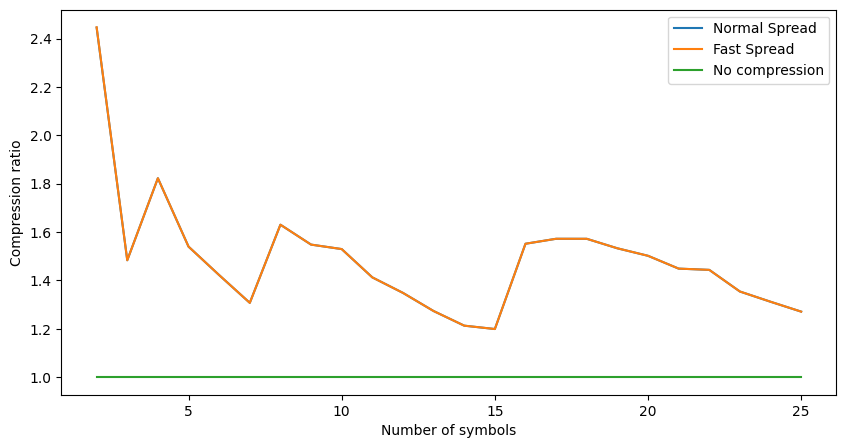

In [37]:
# plot results
plt.figure(figsize=(10,5))
plt.plot(n_symbols, avg_saved, label="Normal Spread")
plt.plot(n_symbols, avg_saved_fast, label="Fast Spread")
plt.plot(n_symbols, [1 for i in n_symbols], label="No compression")
plt.xlabel("Number of symbols")
plt.ylabel("Compression ratio")
plt.legend()
plt.show()

In [38]:
# Seeing how number of symbols affects the compression ratio
n_trials = 50
n_symbols = [i for i in range(2,26,1)]
avg_saved = []
avg_saved_fast = []
avg_time = []
avg_time_fast = []
alphabet_full = ["A", "B", "C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

for n in n_symbols:
    print("Number of symbols:", n)
    alphabet = alphabet_full[:n]
    saved = 0
    saved_fast = 0
    time_taken = 0
    time_taken_fast = 0
    
    for i in range(n_trials):
        freq = generate_normal_distribution_bins(len(alphabet), 1000)
        c = Coder(sum(freq), alphabet, freq, fast= True)
        c_fast = Coder(sum(freq), alphabet, freq, fast= False)
        # encode a message
        msg = generate_random_string(alphabet, freq)
        msg_tmp = list(msg)

        time_start = time.time()
        out_tmp, sav = c.encode_decode(msg_tmp)
        out = "".join(out_tmp)
        time_end = time.time()
        time_taken += time_end - time_start

        time_start = time.time()
        out_tmp_fast, sav_fast = c_fast.encode_decode(msg_tmp)
        out_fast = "".join(out_tmp_fast)
        time_end = time.time()
        time_taken_fast += time_end - time_start

        saved += sav
        saved_fast += sav_fast
        if msg != out or msg != out_fast:
            print("Error")
            print(freq,msg)
            break

    avg_saved.append(saved/n_trials)
    avg_saved_fast.append(saved_fast/n_trials)
    avg_time.append(time_taken/n_trials)
    avg_time_fast.append(time_taken_fast/n_trials)
    
    # print("Normal Spread:", (saved/n_trials), time_taken/n_trials)
    # print("Fast Spread:",(saved_fast/n_trials), time_taken_fast/n_trials)

Number of symbols: 2
Number of symbols: 3
Number of symbols: 4
Number of symbols: 5
Number of symbols: 6
Number of symbols: 7
Number of symbols: 8
Number of symbols: 9
Number of symbols: 10
Number of symbols: 11
Number of symbols: 12
Number of symbols: 13
Number of symbols: 14
Number of symbols: 15
Number of symbols: 16
Number of symbols: 17
Number of symbols: 18
Number of symbols: 19
Number of symbols: 20
Number of symbols: 21
Number of symbols: 22
Number of symbols: 23
Number of symbols: 24
Number of symbols: 25


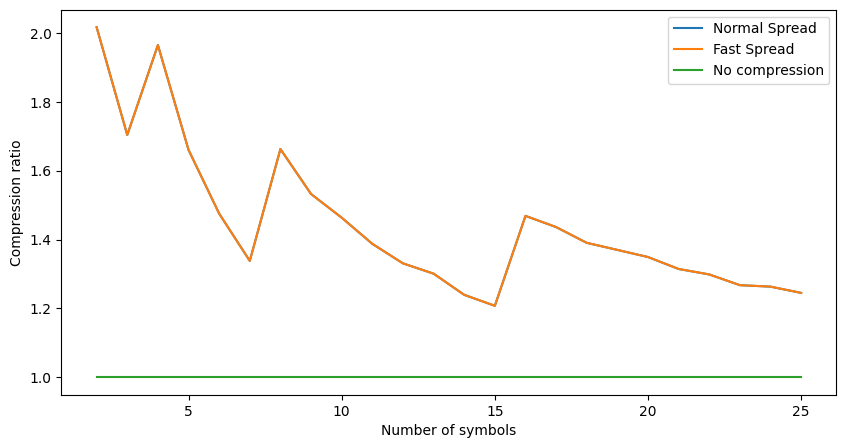

In [39]:
# plot results
plt.figure(figsize=(10,5))
plt.plot(n_symbols, avg_saved, label="Normal Spread")
plt.plot(n_symbols, avg_saved_fast, label="Fast Spread")
plt.plot(n_symbols, [1 for i in n_symbols], label="No compression")
plt.xlabel("Number of symbols")
plt.ylabel("Compression ratio")
plt.legend()
plt.show()